# Shape Interpolation

In [1]:
from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 

from scipy.ndimage import gaussian_filter

import cmocean

## Define Marginals

In [2]:
def sharpen(img):
    blurred = gaussian_filter(img, sigma=7)
    
    blurred[blurred<0.5*np.max(blurred)] = 0.0
    blurred[blurred>0] = 1.0

    blurred /= np.sum(blurred)
    return blurred

def pad(img,pad_size=4):
    temp = np.ones((img.shape[0]+2*pad_size,img.shape[1]+2*pad_size))
    temp[pad_size:-pad_size,pad_size:-pad_size] = img
    return temp

def rescale(img):
    output = np.zeros((2*img.shape[0],2*img.shape[1]))
    output[0::2,0::2] = img 
    output[1::2,0::2] = img 
    output[1::2,1::2] = img 
    output[0::2,1::2] = img 

    return output

#### Load and rescale images

In [3]:
measures = [None]*4
measures[0] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/redcross.png')[:, :, 2])))))
measures[1] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/tooth.png')[:, :, 2])))))
measures[2] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/heart.png')[:, :, 2])))))
measures[3] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/duck.png')[:, :, 2])))))

for i in range(len(measures)):
    measures[i] *= np.prod(measures[i].shape)/np.sum(measures[i])
   
print('Marginal size = ', measures[0].shape)

Marginal size =  (1088, 1088)


In [6]:
measures = [None]*2
measures[0] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/ice_floe_0.png')[:, :, 2])))))
measures[1] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/ice_floe_4.png')[:, :, 2])))))
# measures[2] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/ice_floe_2.png')[:, :, 2])))))
# measures[3] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/ice_floe_3.png')[:, :, 2])))))
# measures[4] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/ice_floe_4.png')[:, :, 2])))))

positions = np.array([[0.78,0.56],                # y position upside down
                      [0.79,0.6]])
r=0.02

for i in range(len(measures)):
    measures[i] *= np.prod(measures[i].shape)/np.sum(measures[i])
#     measures[i] = 1.0 - measures[i]
#     measures[i] = measures[i] + 0.0001
#     measures[i] = (measures[i]/np.sum(measures[i]))*10e4
#     xc, yc = positions[i]
#     measures[i][(x-xc)**2 + (y-yc)**2 < r**2] = 0.6
   
print('Marginal size = ', measures[0].shape)

Marginal size =  (1664, 1664)


### Normalize images to create measures

In [7]:
# Grid of size n1 x n2
n1,n2 = measures[0].shape

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

# Normalize all the measures
for i in range(len(measures)):
    measures[i] *= n1*n2 / np.sum(measures[i])

#### Plot the measures

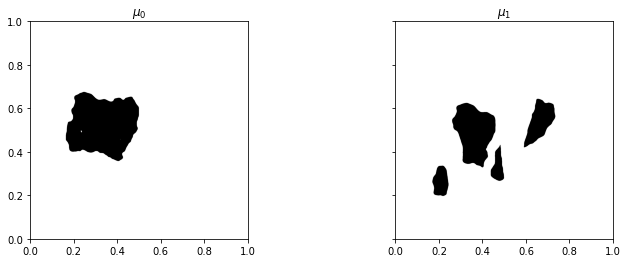

In [8]:
fig, ax = plt.subplots(1, len(measures), figsize=(12,4),sharey=True)
cmap = cmocean.cm.ice
for i in range(len(measures)):
    ax[i].imshow(measures[i], extent=(0,1,0,1), cmap='Greys')
#     ax[i].imshow(measures[i],cmap, extent=(0,1,0,1))
    ax[i].set_title("$\\mu_{{ {:0d} }}$".format(i))

## Solve for Each Barycenter

In [9]:
def SolveForBary(bary_weights):
    unroll_node = 1
    bary_weights /= np.sum(bary_weights)

    # Only keep the measures with positive weights
    keep_inds = np.where(bary_weights>0)[0]
    bary_weights = bary_weights[keep_inds]
    if(len(keep_inds)==1):
        return measures[keep_inds[0]]
    
    keep_measures = [measures[i] for i in keep_inds]

    # Construct the edge list for the barycenter problem
    edge_list = []
    for i in range(len(keep_inds)):
        for j in range(i+1,len(keep_inds)):
            edge_list.append([i,j])

    # Set up the MMOT solver
    prob = MMOTSolver(keep_measures, edge_list, x, y, unroll_node, bary_weights)
    
    # Solve the MMOT problem
    res = prob.Solve(max_its=1000, step_size=1.0, ftol_abs=1e-8, gtol_abs=1e-8, max_line_its=30)
    
    # Use the result to compute the barycenter
    return prob.Barycenter(res.dual_vars)

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.0156,  7.3951e-06,   6.0775e-03,         6
       10,   0.0375,  2.6619e-05,   6.9123e-07,         0
       15,   0.2851,  2.6662e-05,   6.7088e-08,         0
Terminating due to small gradient norm.
Iteration, StepSize,        Cost,        Error,  Line Its


KeyboardInterrupt: 

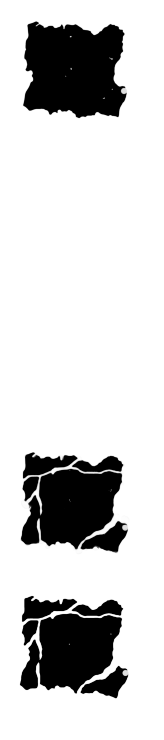

In [89]:
fig=plt.figure(figsize=(8,8)) 

vmax = np.max(measures[0])

size=0.26
corner_pos = np.array([[0.0,1.0], [0.0,0.0], [1.0,1.0], [1.0,0.0]])

for i,m in enumerate(measures):
    ax=fig.add_axes([corner_pos[i,0],corner_pos[i,1],size,size])
    ax.imshow(measures[i],extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
    ax.set_axis_off()

for w1 in np.linspace(0,1,5):
    for w2 in np.linspace(0,1,5):
        weights = [(1.0-w1)*w2, (1.0-w1)*(1.0-w2), w1*w2, w1*(1.0-w2)]
        if(np.max(weights)<1.0-1e-12):
            avg_pos = [w1,w2]
            
            bary = SolveForBary(weights)

            ax=fig.add_axes([avg_pos[0],avg_pos[1],size,size])
            ax.imshow(bary,extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
            ax.set_axis_off()
            
plt.savefig('ShapeInterpolation.pdf',bbox_inches='tight')

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.0039,  1.9411e-05,   7.7509e-03,         8
        8,   0.1001,  8.7990e-05,   9.9587e-06,         0
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.0078,  5.3483e-06,   1.3880e-02,         7
       10,   0.0188,  2.0048e-04,   2.1056e-05,         0
       18,   0.0200,  2.0099e-04,   9.5017e-07,         0
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.0156,  5.1138e-05,   4.5263e-02,         6
       10,   0.0375,  3.6771e-04,   2.9489e-05,         0
       20,   0.0902,  3.7000e-04,   3.7724e-06,         0
       24,   0.0190,  3.7007e-04,   1.1728e-06,         0
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.0156,  5.3878e-05,   4.4769e-02,         6
       10,   0.0375,  2.6568e-04,   4.7427e-05,   

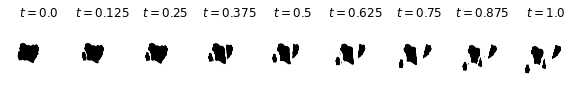

In [7]:

fig=plt.figure(figsize=(8,8)) 

vmax = np.max(measures[0])

size=0.11
# corner_pos = np.array([[0.0,0.0], [1.0,0.0]])

for i,m in enumerate(measures):
    ax=fig.add_axes([(2*i)*size,0.0,size,size])
#     ax.imshow(measures[i],cmap,extent=(0,1,0,1),vmin=0, vmax=vmax)
    ax.imshow(measures[i],extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
    ax.set_axis_off()
    ax.set_title(f"$t={(2*i)*0.125}$")

for i in range(4):
    weights = [0, 0, 0, 0, 0]
    weights[i] = 0.5
    weights[i+1] = 0.5
    avg_pos = [(2*i+1)*size,0.0]
    bary = SolveForBary(weights)
    ax=fig.add_axes([avg_pos[0],avg_pos[1],size,size])
#             ax.imshow(bary,cmap,extent=(0,1,0,1),vmin=0, vmax=vmax)
    ax.imshow(bary,extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
    ax.set_axis_off()
    ax.set_title(f"$t={(2*i+1)*0.125}$")
            
plt.savefig('ShapeInterpolation.pdf',bbox_inches='tight')

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.0156,  2.8729e-04,   1.4643e-01,         6
       10,   0.0063,  1.1660e-03,   5.3325e-04,         0
       20,   0.0038,  1.1681e-03,   2.1142e-05,         0
       27,   0.0007,  1.1683e-03,   7.8760e-06,         6
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.0156,  5.5638e-04,   1.1142e-01,         6
       10,   0.0375,  1.9969e-03,   1.1237e-04,         0
       20,   0.0038,  2.0024e-03,   9.0967e-05,         4
       28,   0.0020,  2.0028e-03,   1.0923e-05,         5
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.0156,  6.6026e-04,   9.9875e-02,         6
       10,   0.0375,  2.4843e-03,   2.5180e-04,         0
       20,   0.0902,  2.5025e-03,   1.7994e-05,         0
       30,   0.0045,  2.5034e-03,   2.4525e-05,         4
       30,   0.0045,  2.5034e-03,   2.

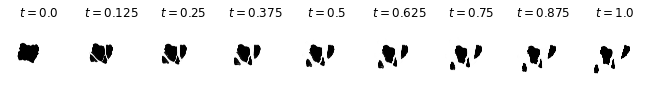

In [12]:
fig=plt.figure(figsize=(8,8)) 

vmax = np.max(measures[0])

size=0.11
corner_pos = np.array([[0.0,0.0], [1.0,0.0]])

for i,m in enumerate(measures):
    ax=fig.add_axes([corner_pos[i,0],corner_pos[i,1],size,size])
#     ax.imshow(measures[i],cmap,extent=(0,1,0,1),vmin=0, vmax=vmax)
    ax.imshow(measures[i],extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
    ax.set_axis_off()

for w1 in np.linspace(0,1,9):
            weights = [(1.0-w1),w1]
            avg_pos = [w1,0.0]
            
            bary = SolveForBary(weights)

            ax=fig.add_axes([avg_pos[0],avg_pos[1],size,size])
#             ax.imshow(bary,cmap,extent=(0,1,0,1),vmin=0, vmax=vmax)
            ax.imshow(bary,extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
            ax.set_axis_off()
            ax.set_title(f"$t={w1}$")
            
plt.savefig('ShapeInterpolation.pdf',bbox_inches='tight')